<a href="https://colab.research.google.com/github/Sair-Shaikh/dali_challenge/blob/main/model1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Loading Dataset

In [1]:
!pip install shap

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
import shap

In [3]:
data = pd.read_csv("/content/superstore processed.csv")

# Data Imputation:

I will attempt to construct a regression model that uses a bunch of features to predict Profit. Out of all the features in the data, these seemed of particular interest in the exploratory analysis and can be reasonably imputed (maintaining the size of the dataset, without skewing results).

In [4]:
data = data[["Ship Mode", "Segment", "City", "State", "Postal Code", "Region", "Category", "Sub-Category", "Sales", "Quantity", "Discount", "Profit", "Shipping Time"]]

For Ship Mode, Segment, and Shipping Time, the data has low spread and the mode is a reasonable choice to replace missing values.

In [5]:
def mode_imputer(columns):
  for column in columns:
    data[column] = data[column].transform(lambda x: x.fillna(data[column].mode()[0]))

mode_imputer(["Ship Mode", "Segment", "Shipping Time"])

The dataset has several categorical variables that depend on each other (Postal Code, City, State, Region, Sub-Category, Category). For instance, the Postal Code feature completely determines the City, the City determines the State, the State determines the Region, and so on. For these variables, I built a function that replaces missing values in Feature 1 by taking a mode across other rows that have the same value for Feature 2 as our target row.


For example, if a particular row has a missing "Region" but has "California" as its State, we look at the mode "Region" of other rows that have "California" as State to fill in the missing value. This also works in reverse, i.e. we replace missing "State" with the most common State within the "Region". The forward propagation introduces no uncertainity, and the backwards one minimizes it reasonably. We perform the forward pass before the backwards.

In [6]:
def cat_imputer(small, big):
  d = {}
  smalls = sorted(data[small].dropna().unique())
  bigs = data.dropna(subset=[small]).groupby(small)[big].agg(pd.Series.mode).tolist()
  for i in range(len(smalls)):
    if(isinstance(bigs[i], str)):
      d[smalls[i]] = bigs[i]
  for idx in d:
    data[big] = np.where(data[small]==idx, d[idx], data[big])


cat_imputer("Postal Code", "City");
cat_imputer("City", "State");
cat_imputer("State", "Region");
cat_imputer("Sub-Category", "Category");
cat_imputer("State", "Postal Code");
cat_imputer("Category", "Sub-Category");

data = data.drop("Postal Code", axis=1)

For these quantitative features, we replace missing values with the mean since the data has a low spread.

In [7]:
data[["Sales", "Quantity", "Discount", "Profit"]] = data[["Sales", "Quantity", "Discount", "Profit"]].fillna(data.mean()["Sales":"Profit"])

The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.


In [8]:
data.isnull().sum()

Ship Mode          0
Segment            0
City             108
State             24
Region             4
Category         111
Sub-Category     111
Sales              0
Quantity           0
Discount           0
Profit             0
Shipping Time      0
dtype: int64

We drop the rows that we could not impute.

In [9]:
data = data.dropna()
data.shape

(9763, 12)

In [10]:
data.corr()

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.


,Sales,Quantity,Discount,Profit
Sales,1.000000,0.193649,-0.027208,0.390444
Quantity,0.193649,1.000000,0.003951,0.062736
Discount,-0.027208,0.003951,1.000000,-0.196567
Profit,0.390444,0.062736,-0.196567,1.000000


# Converting Categorical Data to Numeric:

In [11]:
def to_numeric(cats):
  for cat in cats:
    data.loc[:,cat], _ = pd.factorize(data[cat])

to_numeric(["Ship Mode", "Segment", "City", "State", "Region", "Category", "Sub-Category", "Shipping Time"])


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-uniq

# Setup, Hyperparameter Tuning, and Training a RandomForestRegressor:

Setting up features and label, with a test size of 20%:

In [12]:
y = data["Profit"]
X = data.drop("Profit", axis=1)

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=0)

Choosing a RandomForestRegressor as a compromise between explainability and accuracy. Since we have several features that interact with each other in complex ways, a simple DecisionTree was not able to capture these interactions. Therefore, losing some explainability, I am choosing a RandomForestRegressor.

In [14]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
xgb_regressor = GradientBoostingRegressor(random_state=0)
xgb_regressor.get_params()

{'alpha': 0.9,
 'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'squared_error',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'random_state': 0,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

The most important hyperparameters for RandomForestRegressors are: n_estimators (number of trees used), max_features (number of features considered for best split), max_depth (of each tree), and min_samples_split (minimum samples required to split a node). We also try changing bootstrap (whether to built trees using entire dataset or bootstrap samples).

In [15]:
from sklearn.model_selection import RandomizedSearchCV

# Set up grid for RandomizedSearch
n_estimators = [int(x) for x in np.linspace(start = 150, stop = 1500, num = 10)]
max_depth = [int(x) for x in np.linspace(1, 5, num = 5)]
max_depth.append(None)
max_features = [None, 'sqrt', 'log2']
min_samples_split = [2, 5, 10]

grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split}

In [16]:
xgb_tuned = RandomizedSearchCV(estimator=xgb_regressor, param_distributions=grid, n_iter=100, cv=3, n_jobs=-1, verbose=3, random_state=0)
xgb = make_pipeline(StandardScaler(), xgb_tuned)
xgb.fit(X_train, y_train)
results = xgb.predict(X_test)
xgb.score(X_test, y_test)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


0.4778916607621255

In [29]:
best = xgb["randomizedsearchcv"].best_estimator_

# Explanation:

Setting up and calculating Shapley Values for a random sample of 50 rows:

In [30]:
explainer = shap.TreeExplainer(best)
selection = X_train.sample(50)
shap_values = explainer.shap_values(selection)

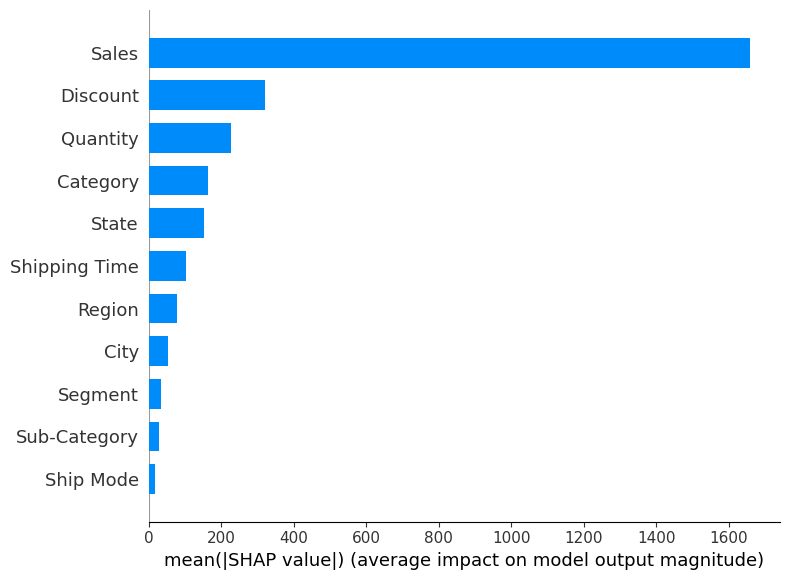

In [31]:
shap.summary_plot(shap_values, X_train, plot_type="bar")

The impact of Sales on the prediction is disproportionate to other variables by a large extent. Other factors that have some influence are interestingly, geographic.

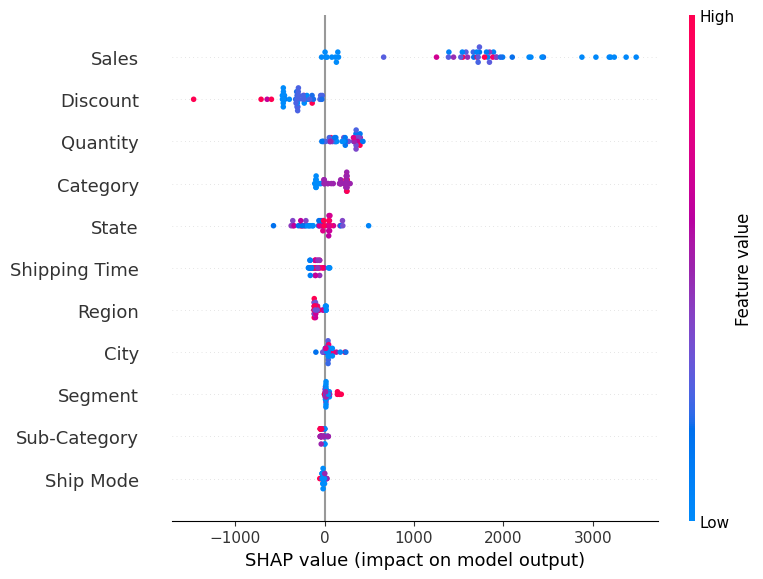

In [32]:
shap.summary_plot(shap_values, selection)

In the force plot, we see how each feature moves the prediction away from the mean prediction of 3,157.75 for a particular example. As predicted, the Sales has a significantly larger effect than other variables.

In [33]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[10], selection.iloc[10])

Interactive plot to observe the effects of individual features on several metrics:

In [34]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0:5,:], selection.iloc[0:5,:], plot_cmap="DrDb")

Plot showing how our regressor makes decisions, with highest impact columns at the top.

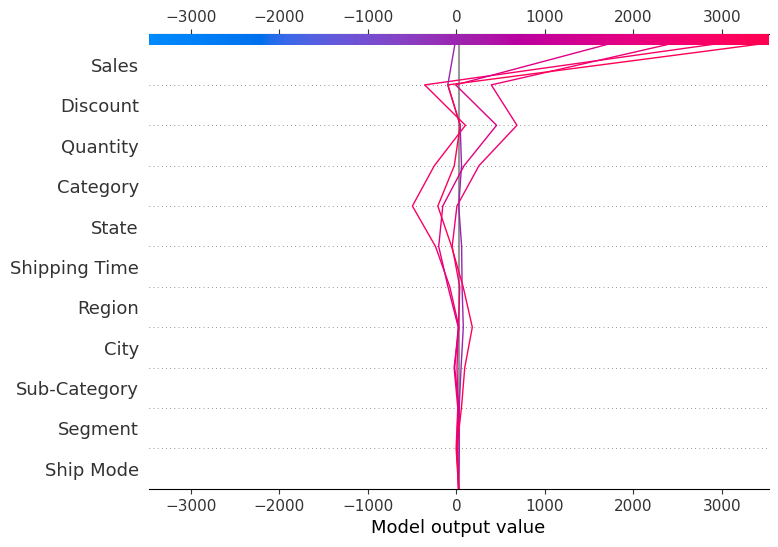

In [35]:
shap.decision_plot(explainer.expected_value, shap_values[:5], selection)